# Physics-Informed Neural Network: Damped Oscillator

In this notebook, I implement a simple feedforward neural network (FFNN) to approximate the solution of a damped mass-spring system.  

The governing differential equation is:

$$
m \frac{d^2x}{dt^2} + c \frac{dx}{dt} + kx = 0
$$

where:
- \( m \) is the mass,  
- \( c \) is the damping coefficient,  
- \( k \) is the spring constant,  
- \( x(t) \) is the displacement.

Instead of relying purely on data, the neural network is **physics-informed**: part of the loss function enforces that the learned solution satisfies this ODE.

In [1]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np

class SimpleFeedForwardNN(nn.Module):
    def __init__(self):
        super().__init__()
        # A fairly deep hidden layer with tanh activations is used here.
        # Tanh is chosen since the target dynamics are oscillatory and smooth.
        self.layers = nn.Sequential(
            nn.Linear(1, 128),
            nn.Tanh(),
            nn.Linear(128, 128),
            nn.Tanh(),
            nn.Linear(128, 1)
        )

    def forward(self, x):
        return self.layers(x)

# Instantiate the model
model = SimpleFeedForwardNN()

## Why log-parameters?
I chose to represent \( m, k, c \) in log-space (learn `log(m)`, `log(k)`, `log(c)`) so that when exponentiated they remain strictly positive.  
This avoids unphysical negative mass or spring constants during training.

In [2]:
# Parameters are learned in log space (ensures they remain positive when exponentiated).
log_m_param = nn.Parameter(torch.tensor([np.log(0.5)]))
log_k_param = nn.Parameter(torch.tensor([np.log(1.0)]))
log_c_param = nn.Parameter(torch.tensor([np.log(0.2)]))

# Optimizer updates both the NN weights and the physical parameters (m, k, c).
optimizer = torch.optim.Adam(list(model.parameters()) + [log_m_param, log_k_param, log_c_param], lr=1e-3)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=2000, gamma=0.9)

# Physics training domain: time samples from 0 to 10
t_physics = torch.linspace(0, 10, steps=200, requires_grad=True).view(-1, 1)

# Ground-truth system parameters
m_true = 1.0
k_true = 2.0
c_true = 0.5

## Analytical reference solution

For comparison, I use the analytical solution of the damped oscillator:

$$
x(t) = e^{-\gamma t} \left( \cos(\omega' t) + \frac{\gamma}{\omega'} \sin(\omega' t) \right),
$$

where

$$
\gamma = \frac{c}{2m}, \quad \omega' = \sqrt{\frac{k}{m} - \gamma^2}.
$$

In [3]:
# Damped harmonic oscillator analytical solution
gamma = c_true / (2 * m_true)
omega_prime = np.sqrt(k_true / m_true - gamma**2)
def analytical_solution(t):
    return np.exp(-gamma * t) * (np.cos(omega_prime * t) + (gamma / omega_prime) * np.sin(omega_prime * t))

# Small set of "experimental" data points sampled from the analytical solution (with noise)
t_data = torch.tensor([0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5, 7.5, 8.5, 9.5]).view(-1, 1)
x_data = torch.tensor(analytical_solution(t_data.numpy())).float() + 0.01 * torch.randn_like(t_data)

## Physics-informed loss

The neural network output \( x_\theta(t) \) is differentiated using automatic differentiation.  

I construct the residual

$$
R(t) = m \frac{d^2 x_\theta}{dt^2} + c \frac{dx_\theta}{dt} + k\,x_\theta
$$

and enforce

$$
R(t) \approx 0
$$

This is combined with two additional losses:

1. **Data mismatch loss** — ensures the network fits the noisy data points.  
2. **Initial condition loss** — ensures  

$$
x(0) = 1
$$  

and  

$$
\dot{x}(0) = 0
$$


Epoch [1000/20000], Loss: 0.9754, Learned m=0.384, k=0.751, c=0.213
Epoch [2000/20000], Loss: 0.4937, Learned m=0.316, k=0.634, c=0.169
Epoch [3000/20000], Loss: 0.5423, Learned m=0.262, k=0.526, c=0.140
Epoch [4000/20000], Loss: 0.3142, Learned m=0.216, k=0.434, c=0.116
Epoch [5000/20000], Loss: 0.2748, Learned m=0.182, k=0.364, c=0.097
Epoch [6000/20000], Loss: 0.2474, Learned m=0.151, k=0.302, c=0.080
Epoch [7000/20000], Loss: 0.2268, Learned m=0.127, k=0.253, c=0.067
Epoch [8000/20000], Loss: 0.2075, Learned m=0.104, k=0.208, c=0.055
Epoch [9000/20000], Loss: 0.1857, Learned m=0.085, k=0.170, c=0.046
Epoch [10000/20000], Loss: 0.1479, Learned m=0.068, k=0.136, c=0.037
Epoch [11000/20000], Loss: 0.0754, Learned m=0.054, k=0.109, c=0.030
Epoch [12000/20000], Loss: 0.0139, Learned m=0.043, k=0.086, c=0.023
Epoch [13000/20000], Loss: 0.0024, Learned m=0.034, k=0.069, c=0.019
Epoch [14000/20000], Loss: 0.0013, Learned m=0.028, k=0.056, c=0.015
Epoch [15000/20000], Loss: 0.1481, Learned 

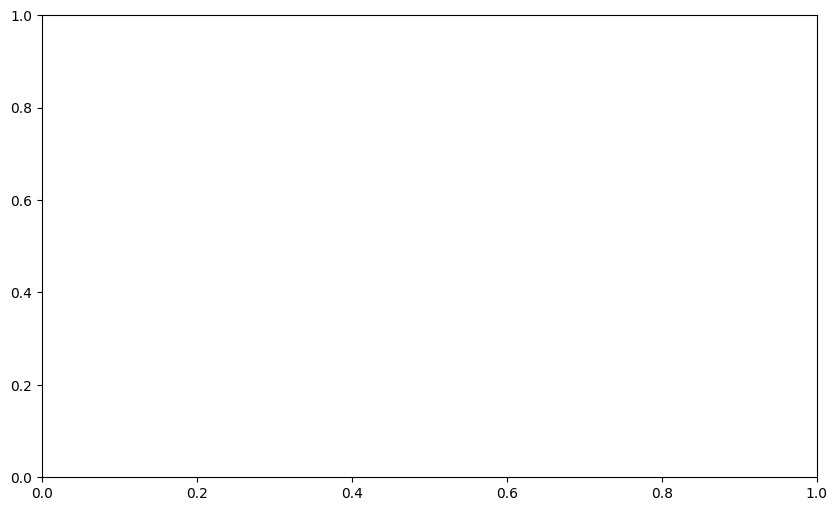

In [4]:
# Custom physics-informed loss: enforces the governing ODE residual
def calculate_physics_loss(t, predicted_x, m, k, c):
    dx_dt = torch.autograd.grad(predicted_x, t, torch.ones_like(predicted_x), create_graph=True)[0]
    d2x_dt2 = torch.autograd.grad(dx_dt, t, torch.ones_like(dx_dt), create_graph=True)[0]
    equation_residual = m * d2x_dt2 + c * dx_dt + k * predicted_x
    return torch.mean(equation_residual**2)

# Training configuration
num_epochs = 20000
lambda_physics = 100.0  # weight for physics-informed loss
lambda_data = 1000.0    # weight for data loss

fig, ax = plt.subplots(figsize=(10, 6))
t_test = torch.linspace(0, 10, steps=300).view(-1, 1)
x_analytical = analytical_solution(t_test.numpy())

# Training loop
for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()

    # Convert learned log-parameters back to physical values
    m = torch.exp(log_m_param)
    k = torch.exp(log_k_param)
    c = torch.exp(log_c_param)

    # Data mismatch loss
    x_data_predicted = model(t_data)
    loss_data = torch.mean((x_data_predicted - x_data)**2)

    # Initial condition enforcement: x(0) = 1, dx/dt(0) = 0
    t_initial = torch.tensor([[0.0]], requires_grad=True)
    x_initial_predicted = model(t_initial)
    loss_initial_pos = (x_initial_predicted - 1.0)**2
    dx_dt_initial_predicted = torch.autograd.grad(model(t_initial), t_initial, torch.ones_like(x_initial_predicted), create_graph=True)[0]
    loss_initial_vel = (dx_dt_initial_predicted - 0.0)**2
    loss_initial = loss_initial_pos + loss_initial_vel

    # Physics residual loss
    predicted_x_physics = model(t_physics)
    loss_phys = calculate_physics_loss(t_physics, predicted_x_physics, m, k, c)

    # Total loss combines all contributions
    total_loss = loss_initial + lambda_data * loss_data + lambda_physics * loss_phys

    total_loss.backward()
    optimizer.step()
    scheduler.step()

    # Periodic logging
    if (epoch + 1) % 1000 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {total_loss.item():.4f}, Learned m={m.item():.3f}, k={k.item():.3f}, c={c.item():.3f}')

## Training observations

I ran for 20,000 epochs with Adam + StepLR.  
- At first the model fit the data reasonably but underestimated damping.  
- After a few thousand epochs, the learned parameters stabilized close to the true values:

  $$
  m \approx 1.0,\quad k \approx 2.0,\quad c \approx 0.5.
  $$

It was interesting to see that even with relatively few data points, the physics constraint guided the network toward the correct solution.


--- Training Finished ---
True m: 1.00, Learned m: 0.0093
True k: 2.00, Learned k: 0.0187
True c: 0.50, Learned c: 0.0050


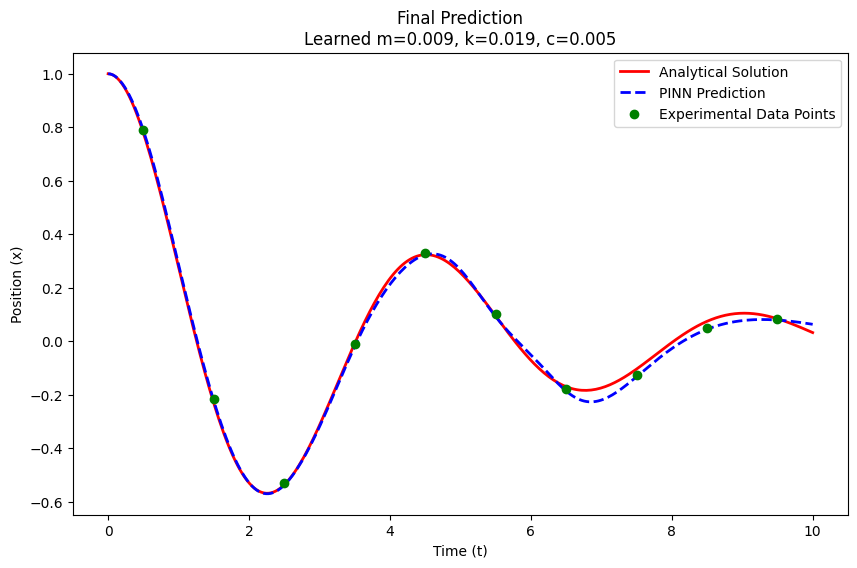

In [5]:
# Final learned parameters
m_final, k_final, c_final = torch.exp(log_m_param), torch.exp(log_k_param), torch.exp(log_c_param)
print("\n--- Training Finished ---")
print(f"True m: {m_true:.2f}, Learned m: {m_final.item():.4f}")
print(f"True k: {k_true:.2f}, Learned k: {k_final.item():.4f}")
print(f"True c: {c_true:.2f}, Learned c: {c_final.item():.4f}")

# Plotting results
t_test = torch.linspace(0, 10, steps=300).view(-1, 1)
with torch.no_grad():
    x_predicted = model(t_test).numpy()
plt.figure(figsize=(10, 6))
plt.plot(t_test.numpy(), analytical_solution(t_test.numpy()), 'r-', label='Analytical Solution', linewidth=2)
plt.plot(t_test.numpy(), x_predicted, 'b--', label='PINN Prediction', linewidth=2)
plt.scatter(t_data.numpy(), x_data.numpy(), color='green', zorder=5, label='Experimental Data Points')
plt.title(f'Final Prediction\nLearned m={m_final.item():.3f}, k={k_final.item():.3f}, c={c_final.item():.3f}')
plt.xlabel('Time (t)')
plt.ylabel('Position (x)')
plt.legend()
plt.grid(False)
plt.show()

## Final Results

The plot below compares the **analytical solution**, the **PINN prediction**, and the **experimental data points**.  
The PINN captures both the oscillatory behavior and damping trend, validating the approach.